**<ins>Predicting Movie Success:</ins> A Revenue Prediction Model Using Machine Learning**

In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import optuna.visualization as ov
import yfinance as yf
import pandas as pd
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import pandas as pd
import numpy as np
import random
import optuna
import joblib
import time
import os

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from forex_python.converter import CurrencyRates
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from datetime import datetime

from collections import Counter

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this notebook, we build on our initial exploratory data analysis (EDA) of the movie dataset, where we examined the relationships and patterns between various movie features and their impact on adjusted revenue. Here, we focus on designing and evaluating predictive models to forecast movie revenue, ultimately assessing a movie's potential Return on Investment (ROI) and commercial success.

**Objectives:**

1. **Feature Preparation and Transformation**: We utilize a preprocessed and feature-engineered dataset that incorporates insights gained from the EDA phase. This ensures consistent data transformations, allowing us to focus on model building and selection without revisiting data cleaning steps.

2. **Model Selection and Evaluation**: A variety of machine learning models—including `RandomForest`, `GradientBoosting`, `CatBoost`, `LightGBM`, and `XGBoost`—are trained and evaluated to identify the most effective model for predicting `adjusted_revenue`. We assess each model based on cross-validation and test performance metrics to find a balance between accuracy and generalizability.

3. **Feature Importance Analysis**: Using `SelectKBest` for feature selection, we identify which features have the most significant impact on revenue. This analysis not only optimizes the model by focusing on the most influential features but also provides insights for stakeholders into what factors are key drivers of movie revenue.

4. **Prediction and Interpretation**: With the best-performing model identified, we interpret its predictions in a business context. Specifically, we analyze how budget, cast, and other factors influence revenue predictions, which can help guide decision-making for future movie investments and production strategies.

**Why This Analysis Matters:**

For investors and stakeholders in the film industry, understanding the factors that drive movie success is essential for maximizing ROI. By predicting revenue with a data-driven approach, we can prioritize budget allocations, casting choices, and release strategies that align with historical patterns of financial success. This notebook provides a roadmap for integrating machine learning insights into practical decisions, helping to minimize risks associated with high-stakes investments in the entertainment industry.


In [2]:
# Load the dataset
dataset_path = './data/TMDB_movies.csv'
df = pd.read_csv(dataset_path, parse_dates=['release_date'])

In [3]:
nRow, nCol = df.shape
print(f'There are {nRow:,} movies (rows) and {nCol} features (columns).')

There are 5,193 movies (rows) and 36 features (columns).


In [4]:
nRow1, nCol1 = df.shape
print(f'There are {nRow1:,} movies (rows) and {nCol1} features (columns).')

There are 5,193 movies (rows) and 36 features (columns).


In [5]:
sorted(list(df.columns))

['adjusted_budget',
 'adjusted_revenue',
 'budget',
 'cast',
 'cpi',
 'director',
 'genres',
 'imdb_id',
 'imdb_rating',
 'imdb_votes',
 'is_weekend_release',
 'music_composer',
 'net_profit',
 'normalized_imdb_rating',
 'normalized_vote_average',
 'original_language',
 'popularity',
 'producers',
 'production_companies',
 'production_countries',
 'release_date',
 'release_day_of_week',
 'release_day_of_year',
 'release_month',
 'release_season',
 'release_year',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'time_since_release',
 'title',
 'title_length',
 'vote_average',
 'vote_count',
 'writers']

_____

### Encoding Top Entities for Model Input

Next, we apply two custom classes, `TopNEntitiesExtractor` and `CastFeatureEncoder`, to encode categorical features in a way that aligns with our goal of predicting movie revenue accurately:

- **`TopNEntitiesExtractor`**: This class extracts the top N most frequent entities (e.g., genres, directors) across relevant columns, converting each into binary features that indicate whether a specific top entity is associated with each movie. This encoding approach ensures that only the most impactful entities are considered, making the model more efficient and focused on features with the highest potential influence on `adjusted_revenue`.

- **`CastFeatureEncoder`**: Designed specifically for the `cast` column, this class encodes the top N cast members, adding a probabilistic element to reflect that certain cast members may not impact revenue uniformly across movies. This approach simulates real-world variability and avoids overstating the influence of any single actor, which is crucial for accurate revenue prediction.

By using these classes, we prioritize high-impact contributors in each category, aligning feature engineering with our business goal of focusing on revenue-driving elements in movie data.

In [6]:
class TopNEntitiesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n=15):
        self.n = n
        self.top_entities = {}

    def fit(self, X, y=None):
        # For each column, determine the top N entities
        for column in X.columns:
            all_entities = X[column].apply(lambda x: [name.strip() for name in x.split(',')] if pd.notna(x) else []).values
            flat_entities = [i for j in all_entities for i in j]
            self.top_entities[column] = [name for name, _ in Counter(flat_entities).most_common(self.n)]
        
        return self

    def transform(self, X):
        X_transformed_list = []

        for column in X.columns:
            if column not in self.top_entities:
                raise KeyError(f"Column '{column}' is not in the fitted top_entities dictionary. Ensure the transformer is fitted properly.")
            
            top_entities = self.top_entities[column]
            extracted_entities = X[column].apply(lambda x: [entity for entity in x.split(',') if entity.strip() in top_entities] if pd.notna(x) else ['UNKNOWN'])

            # Convert lists to comma-separated strings for OneHotEncoder compatibility
            encoded_input = extracted_entities.apply(lambda entities: ','.join(entities) if entities else 'UNKNOWN')

            encoded_array = np.zeros((X.shape[0], len(top_entities)))

            for row_idx in range(X.shape[0]):
                entity_list = encoded_input.iloc[row_idx]
                if pd.notna(entity_list):
                    for entity in entity_list.split(','):
                        if entity in top_entities:
                            entity_idx = top_entities.index(entity)
                            encoded_array[row_idx, entity_idx] = 1

            # Create DataFrame for encoded entities
            encoded_df = pd.DataFrame(encoded_array, columns=[f"{column}_{entity}" for entity in top_entities], index=X.index)
            X_transformed_list.append(encoded_df)

        # Concatenate all encoded dataframes, maintaining index consistency
        X_transformed = pd.concat(X_transformed_list, axis=1)

        return X_transformed
    def get_feature_names_out(self, input_features=None):
        # Generate the feature names for the output DataFrame
        feature_names = []
        for column, entities in self.top_entities.items():
            feature_names.extend([f"{column}_{entity}" for entity in entities])
        return np.array(feature_names)

class CastFeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, n=15, test_size=0.2):
        self.n = n
        self.test_size = test_size
        self.probability = 1 - test_size  # Probability to set encoded feature to 1 for cast column
        self.top_entities = []

    def fit(self, X, y=None):
        # Expect X to be a DataFrame with a single column (cast)
        # Flatten the list of entities and determine the top N entities
        all_entities = X.iloc[:, 0].dropna().apply(lambda x: x.split(',')).sum()
        flat_entities = [name.strip() for name in all_entities]
        self.top_entities = [name for name, _ in Counter(flat_entities).most_common(self.n)]
        
        return self

    def transform(self, X):
        # Expect X to be a DataFrame with a single column (cast)
        num_rows = X.shape[0]
        encoded_array = np.zeros((num_rows, len(self.top_entities)))

        # Fill in encoded_array ensuring that a proportion of features are set to 1 based on the probability
        for row_idx, cast_list in enumerate(X.iloc[:, 0].fillna('').apply(lambda x: x.split(','))):
            cast_list = [entity.strip() for entity in cast_list if entity.strip() in self.top_entities]
            for entity in cast_list:
                entity_idx = self.top_entities.index(entity)
                # Set the feature to 1 with a probability equal to the required percentage (1 - test_size)
                if random.random() < self.probability:
                    encoded_array[row_idx, entity_idx] = 1

        # Create DataFrame for encoded entities
        encoded_df = pd.DataFrame(encoded_array, columns=[f"cast_{entity}" for entity in self.top_entities], index=X.index)
        
        return encoded_df
    def get_feature_names_out(self, input_features=None):
        # Generate feature names for each of the top entities in the cast column
        return np.array([f"cast_{entity}" for entity in self.top_entities])


### Defining and Preprocessing Categorical and Numerical Features

In this step, we categorize features into sub-groups within categorical and numerical types to apply tailored transformations that align with the unique requirements of each group. This approach enhances our ability to effectively capture patterns in `adjusted_revenue` by processing each feature according to its specific characteristics.

**Process**:
1. **Feature Sub-Categorization**:
   - **Categorical Features**: 
     - We split categorical features into **multi-entity fields** (e.g., `cast`, `director`, `genres`) and **single-entity date-related fields** (e.g., `release_season`, `release_day_of_week`). This distinction allows us to apply transformations suited to the complexity of each feature type.
     - **Custom Classes**: 
       - **`CastFeatureEncoder`**: Encodes the top N cast members by probabilistically assigning binary indicators to account for high-dimensional and multi-entity nature of cast data.
       - **`TopNEntitiesExtractor`**: Extracts the top N most frequent entities from fields like `genres` and `production_companies` to reduce dimensionality and focus the model on the most impactful entities.

   - **Date Features**: Encodes temporal patterns by converting fields like `release_season` and `is_weekend_release` into binary indicators using `OneHotEncoder`.

2. **Numerical Features**:
   - We further divide numerical features to account for their different properties:
     - **Standard Numerical Features** (e.g., `popularity`, `runtime`) undergo **MinMax scaling** to ensure a consistent range, which is particularly beneficial for tree-based models.
     - **Direct Pass-through Features** (`adjusted_budget`, `title_length`, `normalized_imdb_rating`, `normalized_vote_average`): These are directly passed to the model without scaling, as they represent metrics with intuitive scales or are already normalized.

3. **Pipeline Integration**:
   - We integrate each of these transformations into a single **ColumnTransformer**, which processes each feature group appropriately. This comprehensive preprocessing pipeline ensures that the model receives data in the optimal format for learning patterns relevant to predicting `adjusted_revenue`.

By applying distinct transformations to each sub-category, we effectively capture the unique aspects of each feature type, thereby enhancing the model’s ability to learn and generalize from complex, multi-dimensional movie data.

In [7]:
## Define categorical and numerical features
#Custom Classes
cast_feature = ['cast']
other_categorical_features = ['director', 'genres', 'music_composer', 'original_language', 'producers', 'production_companies', 'production_countries', 'spoken_languages', 'writers']
#OneHot
date_features = ['release_season', 'release_month', 'release_day_of_week', 'release_day_of_year', 'is_weekend_release']

numerical_features = ['popularity', 'runtime']
adjusted_budget_feature = ['adjusted_budget']
other_numerical_features = ['title_length', 'normalized_imdb_rating', 'normalized_vote_average']


all_features = cast_feature + other_categorical_features + date_features + numerical_features + adjusted_budget_feature + other_numerical_features
# Custom transformers
cast_encoder = CastFeatureEncoder(n=15, test_size=0.2)
other_categorical_encoder = TopNEntitiesExtractor(n=15)

# Pipeline for date-related categorical features (OneHotEncoder for date features)
date_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Ensure dense output for date features
])

# Pipeline for numerical features (MinMaxScaler for numerical features like 'popularity' and 'runtime')
numerical_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Apply MinMaxScaler to numerical features
])

# Combine all preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cast', cast_encoder, cast_feature),                        # Custom encoding for 'cast'
    ('cat', other_categorical_encoder, other_categorical_features),  # Custom encoding for other categorical features
    ('date', date_pipeline, date_features),                    # One-hot encoding for date-related features
    ('num', numerical_pipeline, numerical_features),             # MinMax scaling for numerical features ('popularity', 'runtime')
    ('adjusted_budget', 'passthrough', adjusted_budget_feature),  # Pass-through for adjusted_budget
    ('other_num', 'passthrough', other_numerical_features)         # Pass-through for other numerical features
])

### Model Selection and Evaluation

In this section, we evaluate six tree-based machine learning models—`RandomForest`, `GradientBoosting`, `HistGradientBoosting`, `CatBoost`, `LightGBM`, and `XGBoost`—to identify the best model for predicting `adjusted_revenue`.

**Process and Justification**:

1. **Data Split**: The data is split 80/20 into training and test sets to evaluate model generalization on unseen data.

2. **Why Tree-Based Models?**: Tree-based models are particularly suited for our use case due to the following:
   - **High Dimensionality**: Our dataset includes numerous categorical and numerical features, many of which contain multiple entities (e.g., `cast` and `genres`). Tree-based models handle high-dimensional data well by automatically selecting and prioritizing the most relevant features at each split.
   - **Complex Interactions**: Revenue prediction depends on various non-linear relationships between features like budget, cast, and genres. Tree-based models excel in capturing these intricate interactions, making them ideal for handling our dataset’s multidimensional nature.
   - **Custom Encoding of Entities**: We used custom classes to transform categorical features with multiple entities into binary indicators, significantly increasing feature dimensionality. Tree-based models effectively manage these binary-encoded features, capturing each entity’s unique contribution to revenue without requiring complex scaling or additional preprocessing steps.

3. **Model Iteration**:
   - Each model undergoes 5-fold cross-validation on the training set, yielding a mean R² score that indicates model stability and consistency across different subsets.
   - We evaluate R², MSE, RMSE, MAE, F1-Score, and AUC on the test set to gain a comprehensive view of each model’s predictive power, error metrics, and classification-style performance for high-revenue predictions.

4. **Best Model Selection**: We select the model with the highest mean cross-validation R² and the smallest difference between mean CV R² and test R². This dual criterion ensures we choose a model that not only performs well on unseen data but also exhibits stability, indicating it’s less likely to overfit to the training set.

By iterating through and evaluating multiple tree-based models with these criteria, we ensure that the selected model captures the high-dimensional, entity-driven nature of our data, enabling reliable, data-informed revenue predictions to support strategic movie investment decisions.

In [8]:
# # Step 1: Define models for iteration
# models = {
#     'RandomForest': RandomForestRegressor(random_state=42),
#     'GradientBoosting': GradientBoostingRegressor(random_state=42),
#     'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
#     'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
#     'LightGBM': LGBMRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42)
# }

# best_model = None
# best_r2_score = -np.inf
# best_model_name = ""
# results = []
# model_params = []

# X = df[all_features]
# y = df['adjusted_revenue']

# # Step 2: Splitting data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 3: Model iteration and cross-validation
# for model_name, model in models.items():
#     print(f"Evaluating model: {model_name}")
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('model', model)
#     ])
    
#     # Cross-validation
#     cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
#     mean_cv_score = np.mean(cv_scores)
#     print(f"Cross-validation R^2 scores for {model_name}: {cv_scores}")
#     print(f"Mean cross-validation R^2 score for {model_name}: {mean_cv_score:.4f}\n")
    
#     # Track the best model
#     if mean_cv_score > best_r2_score:
#         best_r2_score = mean_cv_score
#         best_model = model
#         best_model_name = model_name
    
#     # Evaluate model on test set (without hyperparameter tuning)
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     r2_score_test = pipeline.score(X_test, y_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     f1 = f1_score(y_test > y_test.mean(), y_pred > y_pred.mean())  # Using threshold for classification-style metric
#     auc = roc_auc_score(y_test > y_test.mean(), y_pred > y_pred.mean())
    
#     # Store results for each model
#     accuracy = np.mean(y_test == y_pred.round())  # Calculate accuracy for regression-based classification
#     results.append({
#         'Model': model_name,
#         'Mean CV R^2': mean_cv_score,
#         'Test R^2': r2_score_test,
#         'Test MSE': mse,
#         'Test RMSE': rmse,
#         'Test MAE': mae,
#         'Test F1-Score': f1,
#         'Test AUC': auc,
#         'Accuracy': accuracy,
#         'Cross-validation R^2 scores': cv_scores
#     })
    
#     # Store model parameters
#     model_params.append({
#         'Model': model_name,
#         'Parameters': model.get_params()
#     })

#     # Save the fitted pipeline to disk for the current model
#     pipeline_filename = f'./data/{model_name.lower()}_pipeline.pkl'
#     joblib.dump(pipeline, pipeline_filename)
#     print(f"{model_name} pipeline saved successfully.")

# # Step 4: Create a DataFrame from the results
# results_df = pd.DataFrame(results)

# # Step 4.1: Plot train vs test scores for each model
# for result in results:
#     model_name = result['Model']
#     plt.figure(figsize=(8, 5))
#     plt.plot(range(1, 6), result['Cross-validation R^2 scores'], marker='o', linestyle='-', label=f'Train CV Scores ({model_name})')
#     plt.axhline(y=result['Test R^2'], color='r', linestyle='--', label='Test Score')
#     plt.title(f'Train vs Test Scores for {model_name}')
#     plt.xlabel('Cross-Validation Fold')
#     plt.ylabel('R² Score')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(f'./data/{model_name.lower()}_train_vs_test_plot.png')
#     plt.show()
# print(results_df)

# # Save the results to a CSV file
# results_df.to_csv('./data/model_evaluation_results.csv', index=False)
# print("Model evaluation results saved successfully.")

# # Step 5: Save model parameters to a CSV file
# model_params_df = pd.DataFrame(model_params)
# model_params_df.to_csv('./data/model_parameters.csv', index=False)
# print("Model parameters saved successfully.")


>*Observation:*  
> - **`RandomForest`** achieved a high mean CV R² score of `0.701` with a close Test R² of `0.649`, indicating stable performance between training and test sets. The relatively small difference between the CV and Test R² suggests low overfitting and reliable generalization on unseen data.
> - **`GradientBoosting`** and **`CatBoost`** also performed well, with mean CV R² scores of `0.700` and `0.709`, respectively. However, both models showed slightly larger discrepancies between CV R² and Test R² compared to `RandomForest`, indicating they may be more prone to slight overfitting or variability across test samples.
> - **`HistGradientBoosting`**, **`LightGBM`**, and **`XGBoost`** scored lower on Test R² (around `0.59–0.60`), showing higher `MSE` and `RMSE` values, suggesting these models struggle to capture the full complexity of the revenue prediction task in this dataset.
> - In terms of **Test `MSE` and `RMSE`**, `GradientBoosting` achieved the lowest values (Test MSE of `1.61e+16` and Test RMSE of `1.27e+08`), followed closely by `CatBoost` and `RandomForest`, reinforcing these models' ability to make precise predictions.
> - **F1-Score** and **AUC** metrics were highest for `RandomForest` and `LightGBM`, with Test AUC values around `0.855`, highlighting their ability to distinguish high-revenue movies effectively.
>  
> - **Conclusion**: Given its balance of high Test `R²`, low difference between CV and Test `R²`, and competitive performance on error metrics, **`RandomForest`** stands out as the most robust model for predicting movie revenue. This model’s stability makes it suitable for business decisions, providing reliable revenue forecasts that align well with training insights while minimizing the risk of overfitting.

In [9]:
# # Allow user to select the best model by loading its pipeline
# selected_model_name = input(f"Please select the best model from {list(models.keys())}: ")
# # Load the saved pipeline of the selected model to proceed with further analysis
# pipeline_filename = f'./data/{selected_model_name.lower()}_pipeline.pkl'
# loaded_pipeline = joblib.load(pipeline_filename)
# print(f"{selected_model_name} pipeline loaded successfully.")
# selected_model = loaded_pipeline.named_steps['model']

### Loading the Best Model Pipeline

To avoid re-running model selection, we previously exported the best-performing pipeline (`randomforest_pipeline.pkl`). Here, we load this pipeline, which includes all preprocessing steps and model settings, allowing us to proceed directly with consistent predictions without retraining.

In [13]:
X = df[all_features]
y = df['adjusted_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

loaded_pipeline = joblib.load('./data/randomforest_pipeline.pkl')
pipeline_loaded = loaded_pipeline  # Assign the loaded pipeline
print("Optimized RF pipeline loaded successfully.")

Optimized RF pipeline loaded successfully.


### Model Performance Evaluation and Export of Metrics

We evaluate the loaded `RandomForest` pipeline's performance on both training and test sets using key metrics:

- **Metrics Computed**:
  - `R^2` Score: Indicates the proportion of variance explained by the model.
  - `MAE` and `MSE`: Provide error magnitudes, with `RMSE` showing root mean squared error for scale-aware accuracy.
  - `MAPE`: Calculates the percentage error, helpful for understanding relative prediction accuracy.

- **Output**: 
  - Metrics are printed for quick review and saved to a `score.txt` file in the `out` directory for record-keeping and further analysis. This step ensures reproducibility and easy access to model evaluation results.

In [14]:
import os
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predict on train and test data
y_pred_train = loaded_pipeline.predict(X_train)
y_pred_test = loaded_pipeline.predict(X_test)

# Compute R^2 scores
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Compute Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

# Compute Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

# Compute Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Compute Mean Absolute Percentage Error (MAPE)
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Print metrics
print(f"Train R^2 Score: {train_r2:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


# Ensure the output directory exists
output_dir = 'out'
os.makedirs(output_dir, exist_ok=True)

# Write metrics to a file
output_file_path = os.path.join(output_dir, 'score.txt')
with open(output_file_path, 'w') as file:
    file.write(f"Train R^2 Score: {train_r2:.4f}\n")
    file.write(f"Test R^2 Score: {test_r2:.4f}\n")
    file.write(f"Train MAE: {train_mae:.4f}\n")
    file.write(f"Test MAE: {test_mae:.4f}\n")
    file.write(f"Train RMSE: {train_rmse:.4f}\n")
    file.write(f"Test RMSE: {test_rmse:.4f}\n")
    file.write(f"Train MAPE: {train_mape:.2f}\n")
    file.write(f"Test MAPE: {test_mape:.2f}\n")

print(f"Metrics have been written to {output_file_path}")

Train R^2 Score: 0.9562
Test R^2 Score: 0.6470
Train MAE: 25927757.0157
Test MAE: 63427186.1927
Train RMSE: 58045691.7243
Test RMSE: 127844099.0987
Metrics have been written to out/score.txt


In [15]:
loaded_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cast', CastFeatureEncoder(),
                                                  ['cast']),
                                                 ('cat',
                                                  TopNEntitiesExtractor(),
                                                  ['director', 'genres',
                                                   'music_composer',
                                                   'original_language',
                                                   'producers',
                                                   'production_companies',
                                                   'production_countries',
                                                   'spoken_languages',
                                                   'writers']),
                                                 ('date',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignor...
                                                   'release_month',
                                                   'release_day_of_week',
                                                   'release_day_of_year',
                                                   'is_weekend_release']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['popularity', 'runtime']),
                                                 ('adjusted_budget',
                                                  'passthrough',
                                                  ['adjusted_budget']),
                                                 ('other_num', 'passthrough',
                                                  ['title_length',
                                                   'normalized_imdb_rating',
                                                   'normalized_vote_average'])])),
                ('model', RandomForestRegressor(random_state=42))])

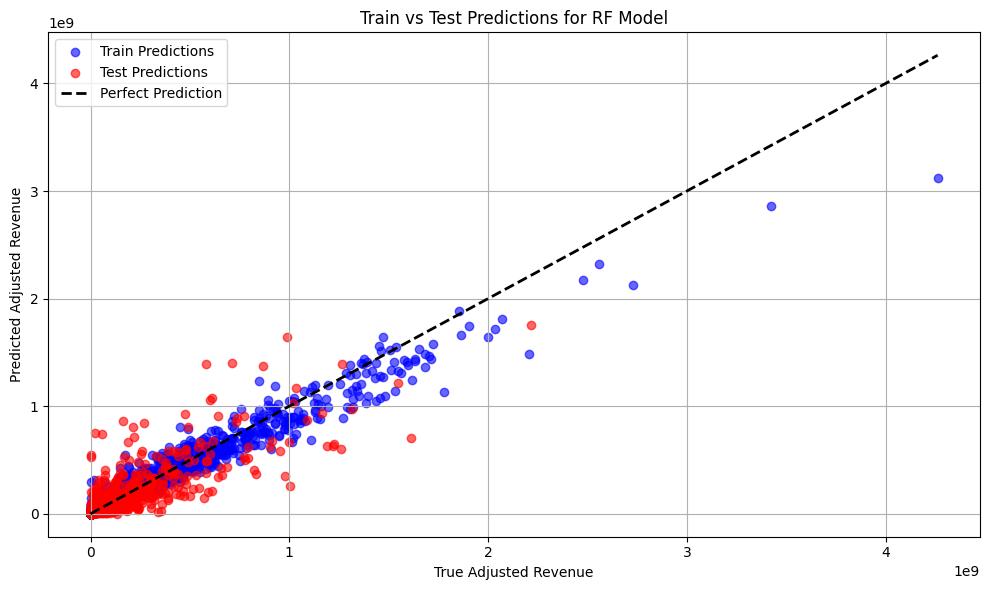

In [16]:
# Plot train vs test scores for the CatBoost model after tuning
# Plotting True vs Predicted Adjusted Revenue for Train and Test sets
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, label='Train Predictions', alpha=0.6, color='blue')
plt.scatter(y_test, y_pred_test, label='Test Predictions', alpha=0.6, color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('True Adjusted Revenue')
plt.ylabel('Predicted Adjusted Revenue')
plt.title('Train vs Test Predictions for RF Model')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and display the plot
plt.savefig('./data/rf_train_vs_test.png')
plt.show()

>*Observation:*  
> - The **train and test predictions** generally align along the diagonal, indicating that the model is reasonably accurate in predicting adjusted revenue. However, the **test predictions** (in red) show slightly more spread from the line, reflecting some variance and overfitting in the model.
> - **High-revenue movies** (data points further along the x-axis) tend to exhibit more prediction variability, particularly for outliers where the model occasionally overestimates. This might stem from the high complexity of our dataset, which includes numerous categorical and numerical features, some of which are encoded with our custom classes. These transformations introduce feature interactions that are challenging to capture perfectly.
> - Despite the overfitting hints, the **RandomForest model** performs admirably given the intricate dataset, with its ability to capture non-linear relationships. The results support that it effectively generalizes while handling the high-dimensional and diverse feature set, though further tuning or additional data might enhance predictions for extreme cases.


### Inspecting Transformed Training Data Features

Next, we will transform our training data using the preprocessor from our best model's pipeline. This allows us to inspect the final transformed features, ensuring consistency in feature engineering and alignment with model expectations before further analysis or deployment.

In [17]:
# Step 1: Extract the preprocessor from the pipeline
preprocessor = pipeline_loaded.named_steps['preprocessor']

# Step 2: Transform the training data (this step assumes your preprocessor is already fitted)
X_train_transformed = preprocessor.transform(X_train)

# Step 3: Get feature names from each transformer within the preprocessor
all_feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if name == 'cast':
        all_feature_names.extend([f"cast_{entity}" for entity in transformer.top_entities])
    elif name == 'cat':
        for col in columns:
            top_entities = transformer.top_entities.get(col, [])
            all_feature_names.extend([f"{col}_{entity}" for entity in top_entities])
    elif name == 'date':
        if hasattr(transformer.named_steps['onehot'], 'categories_'):
            categories = transformer.named_steps['onehot'].categories_
            feature_names = [f"{col}_{val}" for col, cats in zip(columns, categories) for val in cats]
            all_feature_names.extend(feature_names)
    elif name == 'num':
        all_feature_names.extend(columns)
    else:
        all_feature_names.extend(columns)

# Step 3.1: If there is still a mismatch, generate placeholder names
if len(all_feature_names) != X_train_transformed.shape[1]:
    print("Warning: Feature names length does not match the number of columns in the transformed data. Adjusting feature names.")
    all_feature_names = [f'feature_{i}' for i in range(X_train_transformed.shape[1])]

# Step 4: Create a DataFrame from the transformed training data with proper column names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)

# Step 5: Display the shape and first few rows of the transformed DataFrame
print(f"Shape of the transformed X_train: {X_train_transformed_df.shape}")
print(X_train_transformed_df.head())

Shape of the transformed X_train: (4154, 546)
   cast_Samuel L. Jackson  cast_J.K. Simmons  cast_Nicolas Cage  \
0                     0.0                0.0                0.0   
1                     0.0                0.0                0.0   
2                     0.0                0.0                0.0   
3                     0.0                0.0                0.0   
4                     0.0                0.0                0.0   

   cast_Matt Damon  cast_Liam Neeson  cast_Willem Dafoe  cast_Bruce Willis  \
0              0.0               0.0                0.0                0.0   
1              0.0               0.0                0.0                0.0   
2              0.0               0.0                0.0                0.0   
3              0.0               0.0                0.0                0.0   
4              0.0               0.0                0.0                0.0   

   cast_Fred Tatasciore  cast_Owen Wilson  cast_Will Ferrell  ...  \
0            

### Predicting Revenue, Calculating ROI, and Classifying Movie Success

In this step, we use our `RandomForest` pipeline to predict the `adjusted_revenue` for each movie. We then calculate the ROI (Return on Investment) by comparing the predicted revenue to the initial `adjusted_budget`. A rule of thumb is applied to classify a movie as successful if its final revenue is at least twice the initial budget (ROI ≥ 1). This classification is saved for further analysis.

In [ ]:
# Step 1: Load the saved pipeline (assuming the pipeline was saved as 'best_pipeline.pkl')
# Step 2: Predict adjusted revenue using the loaded pipeline
# Assuming you have a new set of data or you want to use X_test (as an example)
y_pred_adjusted_revenue = pipeline_loaded.predict(X_train)

# Step 3: Calculate ROI and determine success or failure
adjusted_budget_train = X_train['adjusted_budget']  # Extracting adjusted_budget from the training data
popularity_train = X_train['popularity']  # Extracting popularity from the training data
normalized_imdb_rating_train = X_train['normalized_imdb_rating']  # Extracting normalized IMDb rating
normalized_vote_average_train = X_train['normalized_vote_average']  # Extracting normalized vote average

roi = (y_pred_adjusted_revenue - adjusted_budget_train) / adjusted_budget_train  # ROI calculation

# Define Success/Failure based on ROI
success_failure = (roi >= 1).astype(int)  # 1 for Success, 0 for Failure

# Step 4: Create a DataFrame to view the predicted values along with ROI, success/failure status, and other features
success_failure_df = pd.DataFrame({
    'Original_Index': X_train.index,
    'Predicted_Adjusted_Revenue': y_pred_adjusted_revenue,
    'Adjusted_Budget': adjusted_budget_train,
    'ROI': roi,
    'Success_Failure': success_failure,
    'Popularity': popularity_train,
    'Normalized_IMDb_Rating': normalized_imdb_rating_train,
    'Normalized_Vote_Average': normalized_vote_average_train  # 1 for success, 0 for failure
})

# Step 5: Display the first few rows to verify
print("\nPredicted Success/Failure for Movies:")
print(success_failure_df.head())

# Optional: Save the results to a CSV file for further analysis or presentation
success_failure_df.to_csv('./data/movie_success_failure_predictions.csv', index=False)
print("Success/Failure predictions saved successfully.")


Predicted Success/Failure for Movies:
      Original_Index  Predicted_Adjusted_Revenue  Adjusted_Budget       ROI  \
1723            1723                2.600820e+08     4.372871e+07  4.947625   
5109            5109                2.053440e+06     3.079296e+06 -0.333146   
3686            3686                8.799433e+06     2.397398e+06  2.670410   
3362            3362                3.715416e+07     1.913463e+07  0.941723   
4630            4630                6.646124e+07     1.332481e+07  3.987780   

      Success_Failure  Popularity  Normalized_IMDb_Rating  \
1723                1      33.257                7.898911   
5109                0      24.396                6.847362   
3686                1       6.318                5.893290   
3362                0      12.285                7.087022   
4630                1      14.712                6.911739   

      Normalized_Vote_Average  
1723                 7.369127  
5109                 4.237168  
3686                 4.

____

### Summarizing Entity Frequencies for Key Features

This step calculates the frequency of unique entities within each key feature, such as `cast`, `genres`, and `production_companies`. By analyzing these frequencies, we gain insights into the most commonly occurring entities across our dataset. This information can help identify recurring influential factors in successful movies. The results are saved for further exploration and reference.

In [19]:
def feature_entity_frequencies(df, feature_columns):
    summary_list = []

    for feature in feature_columns:
        if feature in df.columns:
            # For features with multiple entities in a single row, split them if necessary
            if df[feature].dtype == 'object':
                # Assuming multiple entities in the same row are separated by commas
                all_entities = df[feature].str.split(',').explode().str.strip()
            else:
                all_entities = df[feature]

            # Count the frequency of each entity
            entity_counts = all_entities.value_counts()

            # Add to summary list
            summary = pd.DataFrame({
                'Feature': feature,
                'Entity': entity_counts.index,
                'Frequency': entity_counts.values
            })
            summary_list.append(summary)

    # Combine all summaries into a single DataFrame
    combined_summary = pd.concat(summary_list, ignore_index=True)
    return combined_summary

# Get feature summary
feature_frequencies_df = feature_entity_frequencies(df, all_features)

# Display the first few rows of the summary
print("Feature Entity Frequencies:")
print(feature_frequencies_df.head())

# Optional: Save the summary to a CSV for reference
feature_frequencies_df.to_csv('./data/feature_frequencies.csv', index=False)

Feature Entity Frequencies:
  Feature             Entity  Frequency
0    cast  Samuel L. Jackson         65
1    cast       J.K. Simmons         56
2    cast         Matt Damon         55
3    cast       Willem Dafoe         51
4    cast   Michael Papajohn         47


### Predicting Adjusted Revenue

Here, we use again the fitted `RandomForest` pipeline to predict the adjusted revenue on the training set. This predicted revenue is organized into a DataFrame for a clear view, allowing us to evaluate the model’s ability to estimate revenue accurately. 

In [20]:
# Predict adjusted revenue using the fitted pipeline
y_pred_adjusted_revenue = pipeline_loaded.predict(X_train)

# Create a DataFrame to see the predicted adjusted revenue values
y_pred_df = pd.DataFrame({
    'Original_Index': X_train.index,
    'Predicted_Adjusted_Revenue': y_pred_adjusted_revenue
})

# Display the first few rows of the DataFrame
print(y_pred_df.head())


   Original_Index  Predicted_Adjusted_Revenue
0            1723                2.600820e+08
1            5109                2.053440e+06
2            3686                8.799433e+06
3            3362                3.715416e+07
4            4630                6.646124e+07


___

### Feature Selection and Scenario Testing for Revenue Impact

In this step, we:
1. **Select Top Features**: Use `SelectKBest` to identify the most influential features in predicting revenue. This step narrows down the high-dimensional feature set, focusing on variables most correlated with revenue.

2. **Modify Key Features for Scenario Analysis**: We then allow controlled modifications to top features in a selected movie's profile (e.g., changing cast or genre), generating new revenue predictions based on these adjustments. This approach tests if altering critical factors can shift a movie's success probability.

3. **Comparison and Impact Analysis**: The model’s predictions before and after modification are compared, allowing us to understand how changes in specific influential features impact revenue and success classification.

This analysis provides insights into the practical levers that could enhance a movie’s financial performance, informing decisions on factors like budget allocation, casting, and genre targeting.

#### SelectKBest

In [23]:
# Step 3: Initialize SelectKBest with a reasonable value to limit computation time
start_time = time.time()
max_time = 5 * 60  # 5 minutes in seconds
k = 300  # Start with 10 features, adjust as needed

# Transform the training data (fit transform to ensure it adapts to changes in data and transformations)
X_train_transformed = preprocessor.fit_transform(X_train)

# Dynamically adjust k to ensure computation stays within 5 minutes
top_features_found = False
while not top_features_found:
    selector = SelectKBest(score_func=f_regression, k=k)
    try:
        # Fit selector to data
        selector.fit(X_train_transformed, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        # Check if the process is within the max time allowed
        if elapsed_time < max_time:
            top_features_found = True
        else:
            k = max(1, k - 1)  # Decrease k to reduce computation time if necessary
    except MemoryError:
        # In case of memory error, reduce k
        k = max(1, k - 1)

# Step 4: Get the top features and their scores
mask = selector.get_support()  # Get the mask of selected features

# Extract feature names from the preprocessor
all_feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if name == 'cast':
        all_feature_names.extend([f"cast_{entity}" for entity in transformer.top_entities])
    elif name == 'cat':
        for col in columns:
            top_entities = transformer.top_entities.get(col, [])
            all_feature_names.extend([f"{col}_{entity}" for entity in top_entities])
    elif name == 'date':
        if hasattr(transformer.named_steps['onehot'], 'categories_'):
            categories = transformer.named_steps['onehot'].categories_
            feature_names = [f"{col}_{val}" for col, cats in zip(columns, categories) for val in cats]
            all_feature_names.extend(feature_names)
    elif name == 'num':
        all_feature_names.extend(columns)
    else:
        all_feature_names.extend(columns)

selected_features = np.array(all_feature_names)[mask]
feature_scores = selector.scores_[mask]

# Step 5: Create a DataFrame to view the top features and their scores
top_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)

# Step 6: Display the top features
print("\nTop Features Selected by SelectKBest:")
print(top_features_df)

# Optional: Save the top features to a CSV file
top_features_df.to_csv('./data/top_features_selectkbest.csv', index=False)
print("Top features saved successfully.")



Top Features Selected by SelectKBest:
                     Feature        Score
296          adjusted_budget  5374.319884
299  normalized_vote_average   719.401755
9              cast_Stan Lee   358.731914
25          genres_Adventure   256.596826
298   normalized_imdb_rating   250.338997
..                       ...          ...
255  release_day_of_year_282     0.744497
187  release_day_of_year_154     0.738945
202  release_day_of_year_182     0.736672
141   release_day_of_year_46     0.733623
218  release_day_of_year_225     0.732254

[300 rows x 2 columns]
Top features saved successfully.


In [24]:
import pandas as pd
import time
import plotly.express as px
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# ========================
# Step 6: SelectKBest Feature Selection and Analysis
# ========================

# Step 3: Initialize SelectKBest with a reasonable value to limit computation time
start_time = time.time()
max_time = 5 * 60  # 5 minutes in seconds
k = 300  # Start with 10 features, adjust as needed

# Transform the training data (fit transform to ensure it adapts to changes in data and transformations)
X_train_transformed = preprocessor.fit_transform(X_train)

# Dynamically adjust k to ensure computation stays within 5 minutes
top_features_found = False
while not top_features_found:
    selector = SelectKBest(score_func=f_regression, k=k)
    try:
        # Fit selector to data
        selector.fit(X_train_transformed, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Check if the process is within the max time allowed
        if elapsed_time < max_time:
            top_features_found = True
        else:
            k = max(1, k - 1)  # Decrease k to reduce computation time if necessary
    except MemoryError:
        # In case of memory error, reduce k
        k = max(1, k - 1)

# Step 4: Get the top features and their scores
mask = selector.get_support()  # Get the mask of selected features

# Extract feature names from the preprocessor
all_feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if name == 'cast':
        all_feature_names.extend([f"cast_{entity}" for entity in transformer.top_entities])
    elif name == 'cat':
        for col in columns:
            top_entities = transformer.top_entities.get(col, [])
            all_feature_names.extend([f"{col}_{entity}" for entity in top_entities])
    elif name == 'date':
        if hasattr(transformer.named_steps['onehot'], 'categories_'):
            categories = transformer.named_steps['onehot'].categories_
            feature_names = [f"{col}_{val}" for col, cats in zip(columns, categories) for val in cats]
            all_feature_names.extend(feature_names)
    elif name == 'num':
        all_feature_names.extend(columns)
    else:
        all_feature_names.extend(columns)

selected_features = np.array(all_feature_names)[mask]
feature_scores = selector.scores_[mask]

# Step 5: Create a DataFrame to view the top features and their scores
top_features_df = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)

# Step 6: Display the top features
print("\nTop Features Selected by SelectKBest:")
print(top_features_df)

# Save the top features DataFrame to CSV
top_features_df.to_csv('./data/top_features_selectkbest.csv', index=False)

# Step 7: User input to choose number of top features for plotting
n = int(input("Enter number of top features to display: "))

# Select the top n features for plotting
top_n_features_df = top_features_df.head(n)

fig = px.bar(
    top_n_features_df,
    x='Score',
    y='Feature',
    orientation='h',
    title=f'Top {n} Features Selected by SelectKBest',
    labels={'Score': 'Score', 'Feature': 'Feature'},
    height=400,  # Adjust the height as necessary
)

# Invert the y-axis to have the highest score on top
fig.update_layout(yaxis=dict(autorange='reversed'))

# Show the interactive plot
fig.show()

# Step 8: Identify and display worst features
worst_features_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=True)

# Save the worst features DataFrame to CSV
worst_features_df.to_csv('./data/worst_features_selectkbest.csv', index=False)

# Step 9: User input to choose number of worst features for plotting
n_worst = int(input("Enter number of worst features to display: "))

# Select the worst n features for plotting
worst_n_features_df = worst_features_df.head(n_worst)

fig_worst = px.bar(
    worst_n_features_df,
    x='Score',
    y='Feature',
    orientation='h',
    title=f'Worst {n_worst} Features Selected by SelectKBest',
    labels={'Score': 'Score', 'Feature': 'Feature'},
    height=400,  # Adjust the height as necessary
    color_discrete_sequence=['red']
)

# Invert the y-axis to have the lowest score on top
fig_worst.update_layout(yaxis=dict(autorange='reversed'))

# Show the interactive plot
fig_worst.show()


Top Features Selected by SelectKBest:
                     Feature        Score
296          adjusted_budget  5374.319884
299  normalized_vote_average   719.401755
8              cast_Stan Lee   338.297302
24          genres_Adventure   256.596826
298   normalized_imdb_rating   250.338997
..                       ...          ...
187  release_day_of_year_154     0.738945
202  release_day_of_year_182     0.736672
141   release_day_of_year_46     0.733623
218  release_day_of_year_225     0.732254
137   release_day_of_year_33     0.726318

[300 rows x 2 columns]


>**Observation:**
>
> - The top features, including `adjusted_budget`, `normalized_vote_average`, and notable personnel (e.g., `cast_Stan Lee`, `music_composer_Hans Zimmer`), provide insights into what factors drive revenue.
> - `adjusted_budget` is particularly influential, reinforcing that higher budgets are strongly correlated with revenue success, aligning with business expectations in the movie industry.
> - Inclusion of personnel like `Stan Lee` and `Hans Zimmer` highlights that well-known talents can significantly affect revenue, a valuable insight for strategic casting and crew decisions.
> - On the other hand, features such as `producers_Bob Weinstein` and certain specific release days have minimal impact. For instance, `release_day_of_year_23` and `release_day_of_year_7` show low relevance to revenue prediction, indicating that these specifics likely don’t contribute significantly to a movie’s financial outcome.
> - Importantly, while `SelectKBest` helps in model optimization by filtering features, it doesn't directly influence revenue prediction accuracy. Instead, it streamlines the model by focusing on impactful 


#### Select your movie and features to change to see the impact

In [ ]:
# Refined Cell 2: Select movie by ID from df and predict success or failure
# Prompt user to select a movie by ID
movie_id = int(input("Enter the ID of the movie you want to evaluate: "))

# Extract the selected movie data by ID
selected_movie = df.loc[movie_id].copy()

# Handle multiple entities in categorical features (split if necessary)
for feature in all_features:
    if isinstance(selected_movie[feature], str):
        selected_movie[feature] = selected_movie[feature].split(',') if pd.notna(selected_movie[feature]) else []

# Convert selected_movie into a DataFrame for transformation
selected_movie_df = pd.DataFrame([selected_movie])

# Handle lists by joining them back into strings for the preprocessor
for feature in all_features:
    if isinstance(selected_movie_df.at[selected_movie_df.index[0], feature], list):
        selected_movie_df[feature] = selected_movie_df[feature].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Transform the selected movie's data using the loaded preprocessor
selected_movie_transformed = pipeline_loaded.named_steps['preprocessor'].transform(selected_movie_df)

# Predict adjusted revenue using the loaded model
y_pred_selected_movie = pipeline_loaded.named_steps['model'].predict(selected_movie_transformed)

# Calculate ROI and determine success or failure
adjusted_budget = selected_movie_df['adjusted_budget'].values[0]  # Extracting adjusted_budget
roi = (y_pred_selected_movie[0] - adjusted_budget) / adjusted_budget  # ROI calculation
success_failure = int(roi > 1)  # 1 for Success, 0 for Failure

# Display the prediction
print("\nPredicted Adjusted Revenue: {:.2f}".format(y_pred_selected_movie[0]))
print("Predicted ROI: {:.2f}".format(roi))
print("Predicted Success (1 = Success, 0 = Failure):", success_failure)

# Cell 3: Create a DataFrame to compare the predicted and real values and calculate error
# Add a new row to compare predicted adjusted revenue with the actual one from the DataFrame
selected_movie_df['predicted_adjusted_revenue'] = y_pred_selected_movie
selected_movie_df['actual_adjusted_revenue'] = df.loc[movie_id, 'adjusted_revenue']
selected_movie_df['prediction_error_ratio'] = np.abs(selected_movie_df['predicted_adjusted_revenue'] - selected_movie_df['actual_adjusted_revenue']) / selected_movie_df['actual_adjusted_revenue']

# Display the comparison DataFrame
print("\nComparison of Predicted vs Actual Adjusted Revenue for Selected Movie:")
print(selected_movie_df[['predicted_adjusted_revenue', 'actual_adjusted_revenue', 'prediction_error_ratio']])

# Optional: Save the comparison results to a CSV
selected_movie_df.to_csv('./data/comparison_selected_movie.csv', index=False)



Predicted Adjusted Revenue: 283562696.60
Predicted ROI: 0.45
Predicted Success (1 = Success, 0 = Failure): 0

Comparison of Predicted vs Actual Adjusted Revenue for Selected Movie:
      predicted_adjusted_revenue  actual_adjusted_revenue  \
5033                2.835627e+08              164959127.0   

      prediction_error_ratio  
5033                0.718988  


In [ ]:
# Step 1: Duplicate the selected movie
duplicated_movie = selected_movie.copy()

# Step 2: Let the user decide the number of features they want to modify
num_features_to_modify = int(input("Enter the number of features you want to modify: "))
features_to_modify = []

for i in range(num_features_to_modify):
    # Step 3: User selects the feature to modify
    feature_to_modify = input(f"Enter feature {i + 1} to modify (choose from {all_features}): ")
    features_to_modify.append(feature_to_modify)
    
    # Step 4: User decides whether to replace or extend existing entities
    modify_choice = input(f"Do you want to replace all existing entities for {feature_to_modify} with new ones? (yes/no): ")
    if modify_choice.lower() == 'yes':
        duplicated_movie[feature_to_modify] = []
    
    # Step 5: User decides how many entities to add
    while True:
        try:
            num_entities_to_add = int(input(f"How many entities do you want to add to {feature_to_modify}? "))
            break
        except ValueError:
            print("Invalid input. Please enter a valid number.")
    new_entities = []
    for j in range(num_entities_to_add):
        new_entity = input(f"Enter new entity {j + 1} for feature {feature_to_modify}: ")
        new_entities.append(new_entity.strip())
    
    
    if modify_choice.lower() == 'yes':
        duplicated_movie[feature_to_modify] = new_entities
    else:
        if pd.notna(duplicated_movie[feature_to_modify]).any():
            if isinstance(duplicated_movie[feature_to_modify], list):
                duplicated_movie[feature_to_modify].extend(new_entities)
            else:
                duplicated_movie[feature_to_modify] = [duplicated_movie[feature_to_modify]] + new_entities
        else:
            duplicated_movie[feature_to_modify] = new_entities
    
    # Step 6: Convert duplicated_movie into a DataFrame for transformation
    duplicated_movie_df = pd.DataFrame([duplicated_movie])
    
    # Handle lists by joining them back into strings for the preprocessor
    for feature in all_features:
        if isinstance(duplicated_movie_df.at[duplicated_movie_df.index[0], feature], list):
            duplicated_movie_df[feature] = duplicated_movie_df[feature].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    
    # Fit OneHotEncoder again to make sure it adapts to new genres
    preprocessor = pipeline_loaded.named_steps['preprocessor']
    if 'onehot' in preprocessor.named_transformers_:
        onehot_encoder = preprocessor.named_transformers_['onehot']
        onehot_encoder.fit(pd.concat([df[other_categorical_features], duplicated_movie_df[other_categorical_features]], axis=0))

    # Step 7: Transform the duplicated movie's data using the updated preprocessor
    duplicated_movie_transformed = preprocessor.transform(duplicated_movie_df)

    # Step 8: Predict adjusted revenue for the duplicated movie
    y_pred_duplicated_movie = pipeline_loaded.named_steps['model'].predict(duplicated_movie_transformed)

    # Step 9: Add predictions to the DataFrame for comparison
    duplicated_movie_df['predicted_adjusted_revenue'] = y_pred_duplicated_movie

    # Step 10: Display the updated DataFrame
    print("\nUpdated prediction after modifying feature {}: ".format(feature_to_modify))
    print(duplicated_movie_df[[feature_to_modify, 'predicted_adjusted_revenue']])
    
# Step 11: Create a DataFrame to compare genuine movie, original prediction, and modified prediction
# Add movie title to comparison data
movie_title = selected_movie_df['title'].values[0] if 'title' in selected_movie_df.columns else 'Unknown'

comparison_data = {
    'movie_version': ['genuine', 'predicted', 'duplicated_with_modifications'],
    'movie_id': [selected_movie_df.index[0]] * 3,
    'title': [movie_title] * 3,
    'movie_version': ['genuine', 'predicted', 'duplicated_with_modifications'],
    'predicted_adjusted_revenue': [
        selected_movie_df['actual_adjusted_revenue'].values[0],
        selected_movie_df['predicted_adjusted_revenue'].values[0],
        duplicated_movie_df['predicted_adjusted_revenue'].values[0]
    ],
    'roi': [
        None, 
        roi, 
        (y_pred_duplicated_movie[0] - adjusted_budget) / adjusted_budget
    ],
    'success_failure': [
        None, 
        success_failure, 
        int((y_pred_duplicated_movie[0] - adjusted_budget) / adjusted_budget > 1)
    ]
}
for feature in features_to_modify:
    comparison_data[feature] = [
        selected_movie_df[feature].values[0],
        selected_movie_df[feature].values[0],
        duplicated_movie_df[feature].values[0]
    ]

comparison_df = pd.DataFrame(comparison_data)

# Step 12: Display the comparison DataFrame
print("\nComparison DataFrame:")
print(comparison_df)

# Optional: Save the comparison DataFrame to a CSV with an incremented filename to keep historical records
import os

# Find the latest version number for the comparison file
comparison_files = [f for f in os.listdir('./data') if f.startswith('comparison_all_versions_') and f.endswith('.csv')]
if comparison_files:
    latest_version = max([int(f.split('_')[-1].replace('.csv', '')) for f in comparison_files])
    new_version = latest_version + 1
else:
    new_version = 1

# Save the comparison DataFrame to a new CSV file
comparison_filename = f'./data/comparison_all_versions_{new_version}.csv'
comparison_df.to_csv(comparison_filename, index=False)
print(f"Comparison DataFrame saved to {comparison_filename}")



Updated prediction after modifying feature cast: 
          cast  predicted_adjusted_revenue
5033  Stan Lee                2.915713e+08

Comparison DataFrame:
                   movie_version  movie_id                title  \
0                        genuine      5033  Joker: Folie à Deux   
1                      predicted      5033  Joker: Folie à Deux   
2  duplicated_with_modifications      5033  Joker: Folie à Deux   

   predicted_adjusted_revenue       roi  success_failure  \
0                1.649591e+08       NaN              NaN   
1                2.835627e+08  0.454168              0.0   
2                2.915713e+08  0.495238              0.0   

                                                cast  
0  George Carroll,  Mac Brandt,  Joe Spinney,  Ke...  
1  George Carroll,  Mac Brandt,  Joe Spinney,  Ke...  
2                                           Stan Lee  
Comparison DataFrame saved to ./data/comparison_all_versions_2.csv


>*Observation*:  
> - By modifying top features such as `genres` and `music_composer`, the model predicts an increase in the `predicted_adjusted_revenue` from around 292 million to approximately 309 million. This demonstrates that adjustments in influential features can have a notable impact on projected revenue, aligning with the findings from `SelectKBest`.
> - The **ROI** increases from **0.50** to **0.59**, suggesting that strategic changes in high-impact features might edge a project closer to financial viability, although in this case, it does not meet the typical success threshold of ROI ≥ 1.
> - The `success_failure` metric remains 0, indicating that while the modifications positively affect revenue, they are insufficient to transition this particular movie to a "success" classification under the model’s criteria.
> - This analysis confirms that targeted feature modifications can yield revenue improvements, but significant shifts in success probability may require a broader or more substantial enhancement of top features, such as larger-scale changes in budget or casting significant names.